In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

In [2]:
import ekf

# Nominal trajectory, measurements

In [43]:
class MonoCamera:
    def control(self, X, t):
        u_g = np.sin(0.2*t)
        return u_g
    
    def f(self, X, t):
        g, d = X
        # control
        u_g = self.control(X, t)
        # dynamics
        g_dot = u_g
        d_dot = 0
        x_dot = [g_dot, d_dot]
        return x_dot
    
    def h(self, X, t):
        g, d = X
        y = g/d + np.random.normal(0, 0.2, X.shape[1])
        return np.atleast_2d(y)
    
    def simulate(self, x0, tsim):
        result = odeint(self.f, x0, tsim)
        X = result.T
        U = np.atleast_2d(self.control(X, tsim))
        Y = self.h(X, tsim)
        return X, U, Y

In [44]:
sys = MonoCamera()

x0 = np.array([0, 3])
tsim = np.arange(0, 100, 0.01)

X, U, Y = sys.simulate(x0, tsim)

Text(0, 0.5, 'Measurement values')

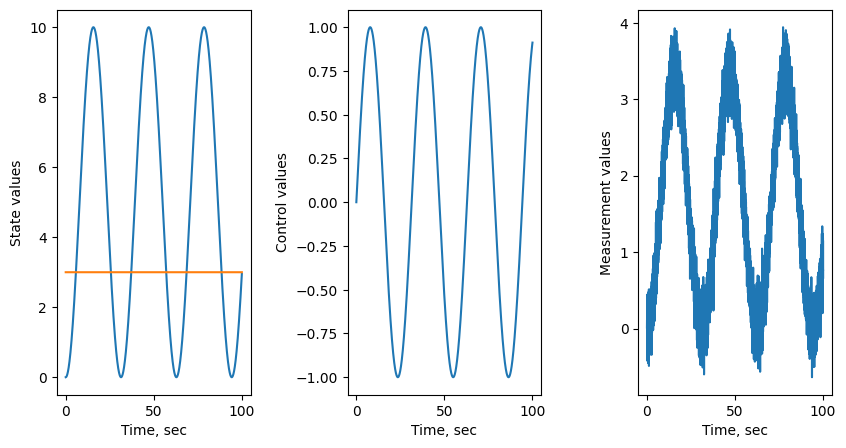

In [45]:
fig = plt.figure(figsize=(10,5))
fig.subplots_adjust(wspace=0.5)

# States
ax = fig.add_subplot(131)

ax.plot(tsim, X[0,:])
ax.plot(tsim, X[1,:])

ax.set_xlabel('Time, sec')
ax.set_ylabel('State values')

# Controls
ax = fig.add_subplot(132)

ax.plot(tsim, U[0,:])

ax.set_xlabel('Time, sec')
ax.set_ylabel('Control values')

# Measurements
ax = fig.add_subplot(133)

ax.plot(tsim, Y[0,:])

ax.set_xlabel('Time, sec')
ax.set_ylabel('Measurement values')

# Extended Kalman Filter

In [46]:
import ekf

In [47]:
def f_d(X, U):
    dt=0.01
    g, d = X
    g_dot = U[0]
    d_dot = 0
    x_new = np.matrix([g + g_dot*dt, d + d_dot*dt]).T
    return x_new

def h_d(X, U):
    g, d = X
    y = np.matrix( g/d )
    return y

In [48]:
# Initial conditions
x0 = np.array([[1], [2]])
P0 = 10*np.eye(2)

# Very little noise
R = 0.2**2*np.eye(1)

# Very accurate model
Q = 1e-5*np.eye(2)

In [49]:
xhat, P_fm, s = ekf.ekf_numerical(Y, x0, f_d, h_d, Q, R, U)

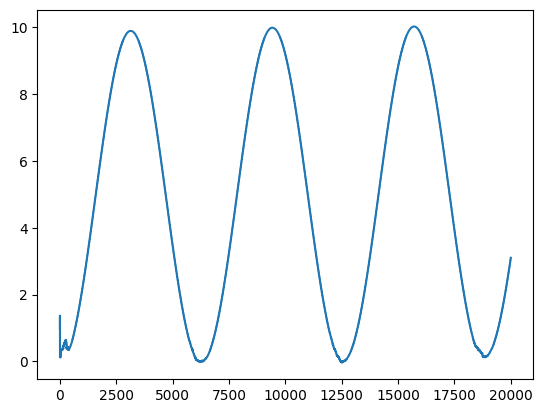

In [50]:
plt.plot(xhat[0,:].T)

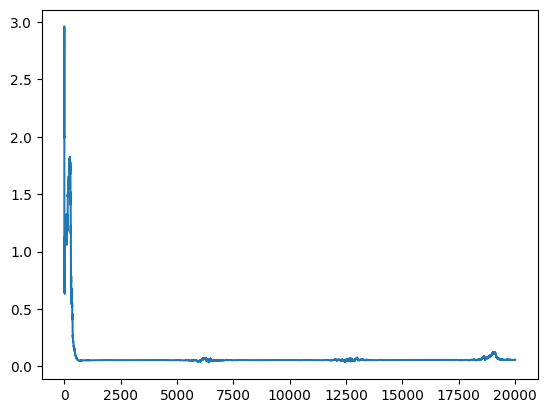

In [51]:
plt.plot(xhat[1,:].T)

# Unscented Kalman Filter

In [52]:
import ukf_sqrt

In [53]:
def f_d(X, U, w):
    dt=0.01
    g = X[0,0]
    d = X[1,0]
    g_dot = U[0,0]
    d_dot = 0
    x_new = np.matrix([g + g_dot*dt, d + d_dot*dt]).T
    return x_new

def h_d(X, U, v):
    g = X[0,0]
    d = X[1,0]
    y = np.matrix( g/d + v[0, :] )
    return y

In [54]:
xhat, P, s = ukf_sqrt.ukf_sqrt(np.matrix(Y), np.matrix(x0), 
                               f_d, h_d, 
                               np.matrix(Q), 
                               np.matrix(R), 
                               np.matrix(U), None)

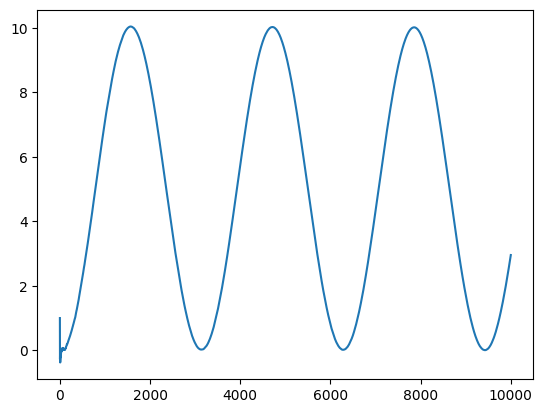

In [55]:
plt.plot(xhat[0,:].T)

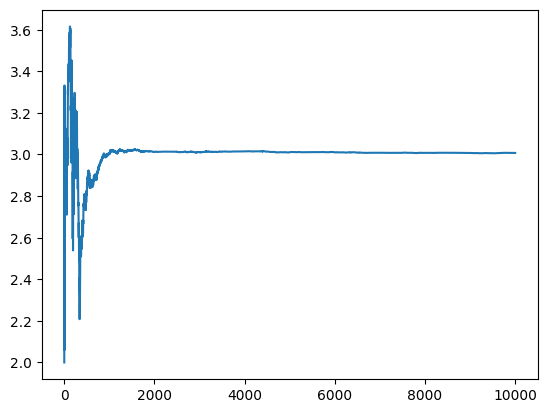

In [56]:
plt.plot(xhat[1,:].T)